## Mounting of Google Drive for use in  Google Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORTATION OF REQUIRED LIBRARIES

In [6]:
!pip install torch -q
import pandas as pd 
import plotly.express as px
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import DataLoader 
from itertools import combinations

## LOADING MY DATA

In [7]:
pos_data=pd.read_csv('/content/drive/MyDrive/BtEurope.csv') #reading from the raw Csv
pos_data.drop_duplicates(inplace=True)
pos_tensors=torch.Tensor(pos_data[['Lat','Lon']].values) #converting the longitudes and the latitudes to tensor format

In [8]:
pos_data

,Lon,Lat,City,Country
0,19.03991,47.49801,Budapest,Hungary
1,11.57549,48.13743,Munich,Germany
2,14.42076,50.08804,Prague,Czech Republic
3,16.37208,48.20849,Vienna,Austria
4,6.77616,51.22172,Dusseldorf,Germany
5,8.68333,50.11667,Frankfurt,Germany
6,8.55000,47.36667,Zurich,Switzerland
7,2.34880,48.85341,Paris,France
8,9.18951,45.46427,Milan,Italy
9,2.15899,41.38879,Barcelona,Spain


## PLOTTING THE LOCATIONS OF THE MAP OF EUROPE

In [9]:
fig = px.scatter_geo(pos_data,lat='Lat',lon='Lon', hover_name="City",scope='europe')
fig.update_layout(title = 'Eurpean Cities', title_x=0.5)
fig.show()

## DEFINING MY  DISTANCE FUNCTION

In [10]:
# THIS FUNCTION CALCULATES THE HAVERSINE DISTANCE BETWEEN TWO POINTS
def haversine(loc1, loc2):
      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
      lat1=loc1[:,0]
      lon1=loc1[:,1]
      lat2=loc2[0]
      lon2=loc2[1]
      dLat = torch.deg2rad(lat2 - lat1)# CONVERTING DEGREES TO RADIANS
      dLon = torch.deg2rad(lon2 - lon1)
      lat1 = torch.deg2rad(lat1)
      lat2 = torch.deg2rad(lat2)
      a = torch.sin(dLat/2)**2 + torch.cos(lat1)*torch.cos(lat2)*torch.sin(dLon/2)**2
      c = 2*torch.asin(torch.sqrt(a))
      return R * c # RETURNS THE HAVERSINE DISTANCE

## DEFINING OUR OBJECTIVE FUNCTIONS

In [396]:
k,l=1,1
m,n=0.01,0.01
p=0.001
q=0.3

In [397]:
# THE FIRST OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS THE MAXIMUM OF THE MINIMUM NODE TO CONTROLLER LATENCY
def maxn2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,7):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = torch.min(min_dists, dists)
  return min_dists.max()
# THE SECOND OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS THE MEAN OF THE MINIMUM NODE TO CONTROLLER LATENCY
def mean2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,7):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = torch.min(min_dists, dists)
    return min_dists.mean()
# THE THIRD OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS MAXIMUM INTERCONTROLLER LATENCY
def maxC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  max_dists = dists
  for i in range(1,7):
    dists = haversine(cont_locs,amb_num[i])
    max_dists = torch.max(max_dists, dists)
  return max_dists.max()
# THE FOURTH OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS DIVISION OF THE SUM OF INTERCONTROLLER LATENCY BY 5C2
def meanC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  sum_dists = dists.sum()
  for i in range(1,7):
    dists = haversine(cont_locs,amb_num[i]).sum()
    sum_dists = sum_dists+ dists
  return (sum_dists/20)
def load_balancing(city_locs,cont_locs):
   node_counts=np.zeros(7)
   for i in range(city_locs.shape[0]):
    dists = haversine(cont_locs,city_locs[i])
    node_counts[np.argmin(dists.clone().detach().numpy())]+=1
   return np.ptp(node_counts)
def max_tolerance(city_locs,cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  max_dists = dists
  for i in range(1,7):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = torch.max(max_dists, dists)
  return max_dists.max()
def all_losses(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs).item()
  l4=meanC2C_fn(cont_locs,cont_locs).item()
  l5=max_tolerance(city_locs,cont_locs).item()
  l6=load_balancing(city_locs,cont_locs)
  return np.array([l1,l2,l3,l4,l5,l6])

In [398]:
def overall_loss(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs)
  l2=mean2C_fn(city_locs,cont_locs)
  l3=maxC2C_fn(cont_locs,cont_locs+0.0001)
  l4=meanC2C_fn(cont_locs,cont_locs+0.0001)
  l5=max_tolerance(city_locs,cont_locs)
  return k*l1 + l*l2+m*l3+n*l4
def overall_metric( city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs).item()
  l4=meanC2C_fn(cont_locs,cont_locs).item()
  l5=max_tolerance(city_locs,cont_locs).item()
  l6=load_balancing(city_locs,cont_locs)
  return (k*l1 + l*l2+m*l3+n*l4+p*l5)*(l6**q)

## GENERATING OUR RANDOM INITIAL LOCATIONS 

In [399]:
import random,numpy
# seeding the environment to enable reproductibility of results
seed=12
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# using torch to generate a random of size 5 by 2
rand_cities =np.random.choice(range(pos_data.shape[0]),7,replace=False)
cont_locs=torch.Tensor(pos_data[['Lat','Lon']].values[rand_cities])# adding the mean of our longitudes and latitudes to enable faster convergence of the model 
initial_locs = cont_locs.clone() # Save originals for later
cont_locs=cont_locs+0.00001 # adding little noise for calculation of gradients 
cont_locs.requires_grad_(True)#TELLS TORCH TO TRACK OPERATIONS ON THE TENSOR
initial_losses=all_losses(pos_tensors,initial_locs)
print('Our starting Cities:',rand_cities)
print('Our starting Locations:',cont_locs.detach().numpy())
print("Initial maxN2c: {1:.2f} meanN2C: {2:.2f} maxICL: {3:.2f} meanICL: {4:.2f}  ".format(0,initial_losses[0],initial_losses[1],initial_losses[2],initial_losses[3]))
print("Overall for initial locs: {:.2f} ".format(initial_losses.sum()))

Our starting Cities: [ 7  9 10 20 13  8 14]
Our starting Locations: [[48.85342     2.34881   ]
 [41.3888      2.159     ]
 [50.05001    -5.19999   ]
 [59.332592   18.064909  ]
 [55.675953   12.565539  ]
 [45.464283    9.18952   ]
 [51.50854    -0.12573001]]
Initial maxN2c: 489.01 meanN2C: 441.27 maxICL: 1416.41 meanICL: 1452.65  
Overall for initial locs: 4988.71 


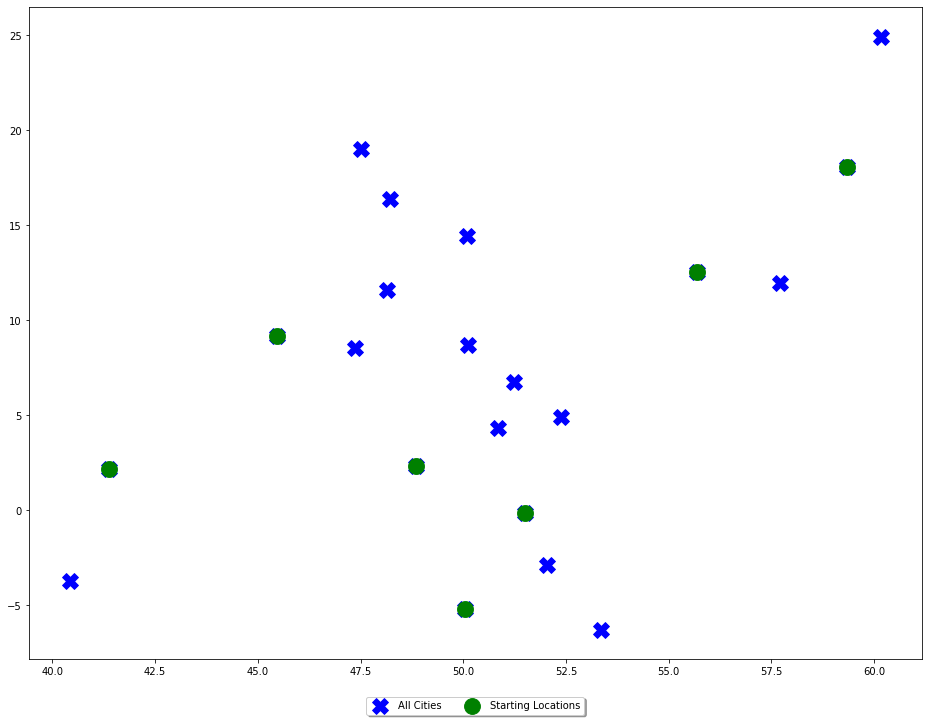

In [400]:
from matplotlib.pyplot import figure
figure(figsize=(16, 12))
plt.scatter(pos_data['Lat'],pos_data['Lon'], s=250, c='blue',marker="X",label='All Cities')
plt.scatter(initial_locs.detach().numpy() [:,0],initial_locs.detach().numpy() [:,1], s=250, c='green',label='Starting Locations')#plt.size()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

## TRAINING THE MODEL 

In [401]:
# setting our training parameters 
lr=0.1
n_epochs = 200
momentum = 0.8
lr_decay = 0.65
# dataloader to load our data in batches, here we are using a batch size of 7
dl = DataLoader(pos_tensors, batch_size=11, shuffle=False)
# Store loss over time
train_losses = []
val_losses = []
losses_sum=[]
val_losses_sum = []
verbose=4
early_stopping=10
change = 0
best_loss=initial_losses
# for keeping the best locs 
final_locs=cont_locs.clone()
for epoch in range(n_epochs):
  new_lr = lr/(1+epoch*lr_decay)
   # Run through batches
  for pos_tensor in dl:
   # print(mean2C_fn(pos_tensor,cont_locs).item())
    loss =overall_loss(pos_tensor,cont_locs)
    loss.backward() # Calc grads
    new_change = new_lr * cont_locs.grad.data + momentum *change
    cont_locs.data -= new_change # Update locs
    change = new_change
    cont_locs.grad = None # Reset gradients for next step
  train_losses.append(all_losses(pos_tensor,cont_locs))
  val_loss=all_losses(pos_tensors,cont_locs)
  losses=overall_metric(pos_tensors,cont_locs)
  val_overall = overall_metric(pos_tensor,cont_locs)
  if epoch>0 :
    if losses< np.min(losses_sum):
       final_locs=cont_locs.clone()
       best_loss=val_loss
  #val_losses.append(val_loss)
  losses_sum.append(losses)
  val_losses.append(val_loss)
  val_losses_sum.append(val_overall)
  #losses_sum.append(losses)
  if epoch % verbose==0:
   print("After {0:.0f} epochs: maxN2c: {1:.2f} meanN2C: {2:.2f} maxICL: {3:.2f} meanICL: {4:.2f} Max Tolerance:{5:.2f} Load Balancing:{6:.2f} Overall: {7:.2f} ".format(epoch,val_loss[0],val_loss[1],val_loss[2],val_loss[3],val_loss[4],val_loss[5],losses))
  if epoch > early_stopping:
    if np.min(losses_sum[-early_stopping:])> np.min(losses_sum):
      print ('Training ended by early stopping, best score at epoch {}'.format(epoch-early_stopping))
      break 
print("Best scores at epoch {0} maxN2c: {1:.2f} meanN2C: {2:.2f} maxICL: {3:.2f} meanICL: {4:.2f} Max tolerance:{5:.2f} Load Balancing:{6:.2f} Overall: {7:.2f} ".format(epoch-early_stopping,best_loss[0],best_loss[1],best_loss[2],best_loss[3],best_loss[4],best_loss[5],overall_metric(pos_tensors,final_locs)))

After 0 epochs: maxN2c: 483.92 meanN2C: 404.07 maxICL: 1629.31 meanICL: 1583.31 Max Tolerance:1033.88 Load Balancing:4.00 Overall: 1396.20 
After 4 epochs: maxN2c: 412.57 meanN2C: 443.25 maxICL: 2290.23 meanICL: 2323.50 Max Tolerance:996.50 Load Balancing:7.00 Overall: 1618.80 
After 8 epochs: maxN2c: 315.10 meanN2C: 420.86 maxICL: 2159.36 meanICL: 2069.67 Max Tolerance:944.78 Load Balancing:6.00 Overall: 1333.80 
After 12 epochs: maxN2c: 270.72 meanN2C: 420.89 maxICL: 2048.06 meanICL: 1998.38 Max Tolerance:943.70 Load Balancing:6.00 Overall: 1254.76 
After 16 epochs: maxN2c: 300.44 meanN2C: 418.25 maxICL: 1970.84 meanICL: 1988.12 Max Tolerance:999.52 Load Balancing:6.00 Overall: 1299.71 
After 20 epochs: maxN2c: 294.76 meanN2C: 412.50 maxICL: 1913.76 meanICL: 1983.73 Max Tolerance:923.54 Load Balancing:6.00 Overall: 1278.96 
After 24 epochs: maxN2c: 253.72 meanN2C: 408.45 maxICL: 1910.92 meanICL: 1961.33 Max Tolerance:942.07 Load Balancing:6.00 Overall: 1201.37 
After 28 epochs: maxN2

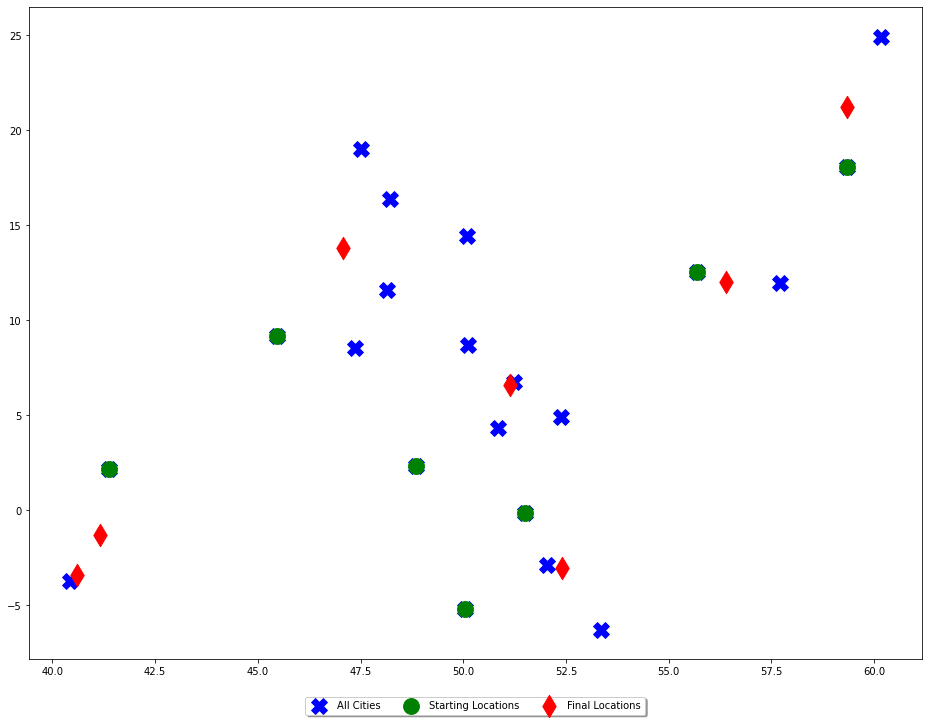

In [402]:
figure(figsize=(16, 12))
plt.scatter(pos_data['Lat'],pos_data['Lon'], s=250, c='blue',marker="X",label='All Cities')
plt.scatter(initial_locs.detach().numpy() [:,0],initial_locs.detach().numpy() [:,1], s=250, c='green',label='Starting Locations')
plt.scatter(final_locs.detach().numpy() [:,0],final_locs.detach().numpy() [:,1], s=250,marker="d", c='red',label='Final Locations')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

In [403]:
val_losses=np.array(val_losses)
train_losses=np.array(train_losses)

In [404]:
def plot_model_performance(val_losses,train_losses):
    """Plot model performance"""
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses[:,0], label = "Training maxN2C")
    plt.plot(val_losses[:,0], label="Validation maxN2C")
    plt.legend()
    plt.title("Training maxN2C vs Validation maxN2C")

    plt.subplot(2,2,2)
    plt.plot(train_losses[:,1], label = "Training meanN2C")
    plt.plot(val_losses[:,1], label="Validation meanN2C")
    plt.legend()
    plt.title("Training meanN2C vs Validation meanN2C")
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses[:,2], label = "Training maxC2C")
    plt.plot(val_losses[:,2], label="Validation maxC2C")
    plt.legend()
    plt.title("Training maxC2C vs Validation maxC2C")

    plt.subplot(2,2,2)
    plt.plot(train_losses[:,3], label = "Training meanC2C")
    plt.plot(val_losses[:,3], label="Validation meanC2C")
    plt.legend()
    plt.title("Training meanC2C vs Validation meanC2C")
    plt.show()

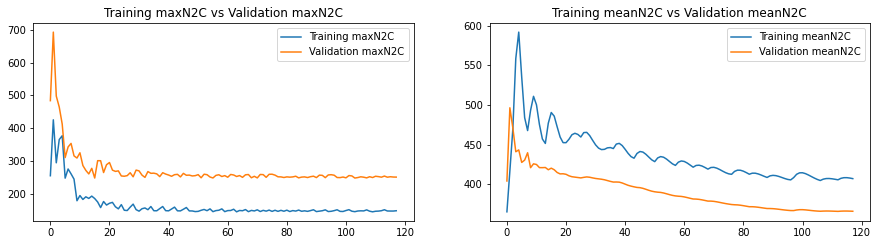

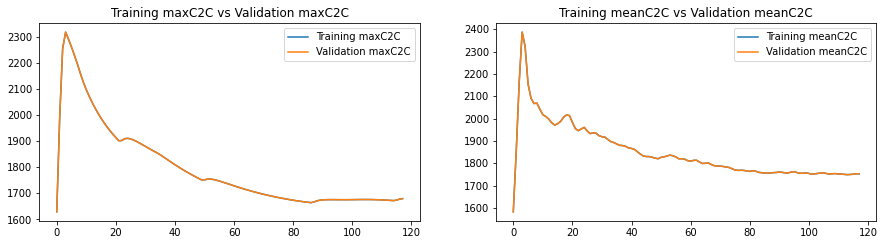

In [405]:
plot_model_performance(val_losses,train_losses)

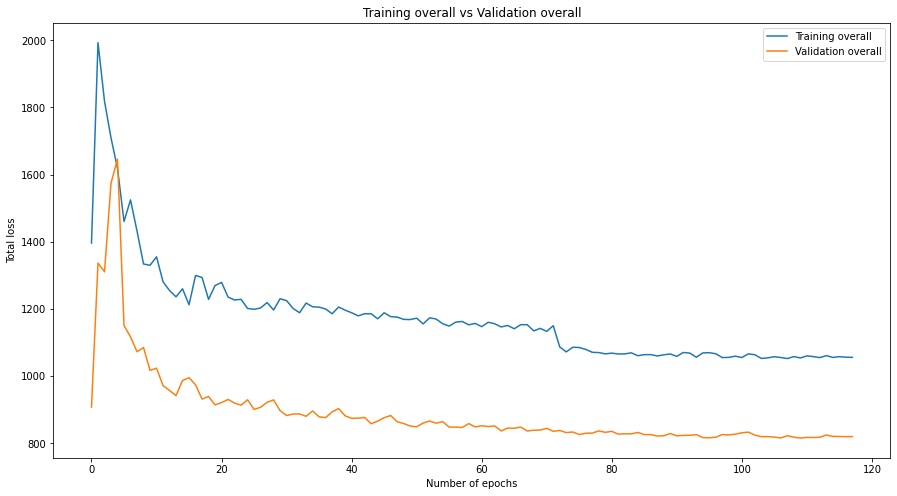

In [406]:
plt.figure(figsize=(15, 8))
#plt.plot(train_losses.sum(axis=1), label = "Training overall")
plt.plot(losses_sum, label = "Training overall")
plt.plot(val_losses_sum, label="Validation overall")
#plt.plot(val_losses.sum(axis=1), label="Validation overall")
plt.legend()
plt.title("Training overall vs Validation overall")
plt.xlabel('Number of epochs')
plt.ylabel('Total loss')
plt.show()

In [407]:
def loc_to_cities(cont_locs):
  cont_locs=cont_locs.detach()
  min_dists=[]
  for loc in cont_locs:
    dists=haversine(pos_tensors,loc).detach().numpy()
    min_dists.append(np.argmin(dists))
  return min_dists

In [408]:
print(loc_to_cities(final_locs))

[4, 11, 11, 20, 13, 1, 15]
